<a href="https://colab.research.google.com/github/emmapraise/Sentiment-Analysis/blob/master/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 24.2MB 138kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.1.4)


In [6]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [8]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [10]:
os.chdir('/content/drive/MyDrive/Twitter Sentiment Analysis/')

In [12]:
# !unzip archive.zip

Archive:  archive.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [13]:
!ls

archive.zip				   twitter-sentiment-analysis.ipynb
training.1600000.processed.noemoticon.csv


In [15]:
os.listdir()[-1]

'training.1600000.processed.noemoticon.csv'

In [16]:
dataset_filename = os.listdir()[-1]
# dataset_path = os.path.join("..","input",dataset_filename)
# print("Open file:", dataset_path)
df = pd.read_csv(dataset_filename, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [17]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [18]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [19]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [20]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 422 ms, sys: 2.6 ms, total: 424 ms
Wall time: 426 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

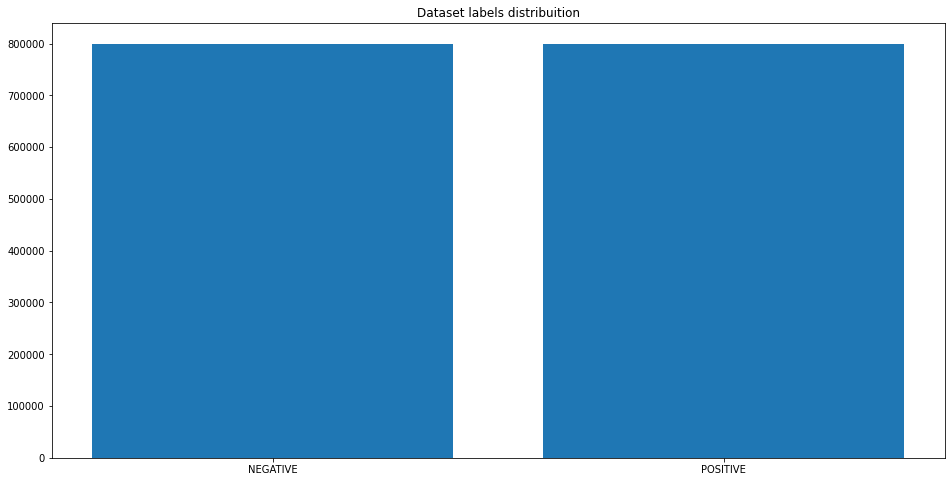

In [21]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [22]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [23]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [24]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 41.2 s, sys: 143 ms, total: 41.4 s
Wall time: 41.4 s


### Split train and test

In [25]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [26]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.57 s, sys: 303 ms, total: 2.88 s
Wall time: 2.88 s


In [28]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [29]:
w2v_model.build_vocab(documents)

2020-11-21 22:30:16,084 : INFO : collecting all words and their counts
2020-11-21 22:30:16,086 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-21 22:30:16,112 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-11-21 22:30:16,129 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-11-21 22:30:16,151 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-11-21 22:30:16,169 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-11-21 22:30:16,191 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-11-21 22:30:16,212 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-11-21 22:30:16,233 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-11-21 22:30:16,251 : INFO : PROGRESS: at s

In [30]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [31]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-11-21 22:31:45,311 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-11-21 22:31:46,387 : INFO : EPOCH 1 - PROGRESS: at 5.32% examples, 410966 words/s, in_qsize 14, out_qsize 1
2020-11-21 22:31:47,429 : INFO : EPOCH 1 - PROGRESS: at 10.42% examples, 406489 words/s, in_qsize 14, out_qsize 1
2020-11-21 22:31:48,484 : INFO : EPOCH 1 - PROGRESS: at 16.05% examples, 421282 words/s, in_qsize 14, out_qsize 3
2020-11-21 22:31:49,477 : INFO : EPOCH 1 - PROGRESS: at 21.35% examples, 422638 words/s, in_qsize 14, out_qsize 1
2020-11-21 22:31:50,504 : INFO : EPOCH 1 - PROGRESS: at 26.56% examples, 421352 words/s, in_qsize 15, out_qsize 3
2020-11-21 22:31:51,580 : INFO : EPOCH 1 - PROGRESS: at 32.62% examples, 428618 words/s, in_qsize 15, out_qsize 0
2020-11-21 22:31:52,707 : INFO : EPOCH 1 - PROGRESS: at 38.35% examples, 427375 words/s, in_qsize 15, out_qsize 2
2020-11-21 22:31:53,741 : INFO : EPOCH 1 - PROGRESS: 

CPU times: user 20min 9s, sys: 4.5 s, total: 20min 14s
Wall time: 10min 22s


(263120780, 295270528)

In [37]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('luv', 0.5755434036254883),
 ('loves', 0.5592329502105713),
 ('loved', 0.5340205430984497),
 ('adore', 0.5216896533966064),
 ('amazing', 0.49476635456085205),
 ('looove', 0.47774532437324524),
 ('loveee', 0.4584970474243164),
 ('loooove', 0.4564161002635956),
 ('awesome', 0.4544089436531067),
 ('lovee', 0.4486658573150635)]

In [38]:
# w2v_model.similarity('love', 'luv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.57554334

### Tokenize Text

In [39]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 14.9 s, sys: 90.9 ms, total: 15 s
Wall time: 15 s


In [40]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 23.1 s, sys: 479 ms, total: 23.6 s
Wall time: 23.6 s


### Label Encoder 

In [41]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [42]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

[1 1 1 ... 0 0 0]
[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]
y_train (1280000, 1)
y_test (320000, 1)


In [43]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [44]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [45]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [46]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [47]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2020-11-21 22:54:01,466 : WARNING : Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [48]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [49]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
 468/1125 [===========>..................] - ETA: 5:50 - loss: 0.5234 - accuracy: 0.7361

### Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

In [ ]:
predict("I hate the rain")

In [ ]:
predict("i don't know what i'm doing")

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

### Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)